In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser
from sklearn.utils import shuffle
import math
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

importing Jupyter notebook from imagePreProcessor.ipynb


2023-06-27 11:08:47.625595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2'

In [3]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset/')

In [105]:
df = pd.read_csv("tesseract6.csv")
df = shuffle(df, random_state=2)

In [106]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [107]:
df.shape

(195, 33)

In [108]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,...,invoice y,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,imageName,output
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.0,195.0,195.0,195.0,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,148.528205,154.066667,0.544255,0.356838,3482.369231,2576.343590,0.0,0.0,0.0,0.0,...,0.093127,0.054528,0.090108,0.009957,0.171315,0.165585,1.087214,0.564707,46.471795,0.358974
std,87.701303,87.340728,0.277128,0.219835,500.880644,328.723664,0.0,0.0,0.0,0.0,...,0.148099,0.109584,0.146999,0.045927,0.179321,0.176302,1.207574,0.541161,29.175137,0.480934
min,1.000000,0.000000,0.059795,0.019529,1566.000000,1134.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,71.500000,78.000000,0.305414,0.181143,3300.000000,2479.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.500000,0.000000
50%,147.000000,155.000000,0.503426,0.284848,3500.000000,2481.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.142121,0.135975,0.643405,0.569923,45.000000,0.000000
75%,223.000000,230.500000,0.818442,0.474214,3508.000000,2550.000000,0.0,0.0,0.0,0.0,...,0.161714,0.050756,0.159232,0.000000,0.266291,0.259497,1.721812,0.805795,69.500000,1.000000
max,297.000000,298.000000,0.941556,0.978286,5313.000000,3542.000000,0.0,0.0,0.0,0.0,...,0.904848,0.853763,0.904848,0.380844,0.790479,0.790479,4.311165,2.623136,107.000000,1.000000


In [109]:
df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)

In [110]:
df

,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice,...,invoice y,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,imageName,output
179,04/07/2022,0.110401,0.415758,3300,2192,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.360909,0.360909,0.132299,0.721818,60,0
221,"jan 29, 2022 to",0.393707,0.520000,3500,2479,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.358857,0.358857,0.392900,0.717714,69,0
226,10-oct-2022,0.856078,0.162424,3300,2550,0,0,0,0,1,...,0.119091,0.119091,0.119091,0.0,0.161515,0.161515,3.861569,0.680303,71,1
7,27-feb-23,0.898039,0.283636,3300,2550,0,0,0,0,1,...,0.244848,0.244848,0.244848,0.0,0.244848,0.244848,3.763922,1.224242,3,0
30,10/12/2022,0.120000,0.485758,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.364848,0.364848,0.174118,0.729697,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,"mar 28, 2023 to mar 27, 2024",0.463090,0.311714,3500,2479,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,69,0
47,date :24-sep-22:,0.395539,0.125729,5313,3542,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.125729,0.125729,0.687747,0.251459,13,1
213,31-mar-2023,0.274708,0.151653,3508,2479,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.135690,0.135690,0.212989,0.271380,67,0
22,11/12/2022 12:00:00 pm,0.843922,0.298485,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.298182,0.298182,1.154510,0.596364,8,0


In [111]:
df.sort_values("imageName", inplace=True)

In [112]:
df

,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice,...,invoice y,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,imageName,output
1,21-07-2022,0.772892,0.081050,3504,2479,0,0,0,0,1,...,0.038813,0.038813,0.038813,0.0,0.067922,0.067922,2.963292,0.252283,1,1
4,22-sep-22,0.217426,0.148687,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.147546,0.147546,0.224284,0.295091,2,1
2,1-oct-22. to 31,0.751109,0.561358,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.493721,0.493721,1.342477,0.987443,2,0
3,1-oct-22.,0.719645,0.561358,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.493721,0.493721,1.342477,0.987443,2,0
6,1-mar-23,0.890980,0.247273,3300,2550,0,0,0,0,1,...,0.244848,0.244848,0.244848,0.0,0.244848,0.244848,3.763922,1.224242,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,24-jan-2023,0.793062,0.077340,3504,2479,0,0,0,0,1,...,0.069349,0.034247,0.034247,0.0,0.065639,0.065639,3.110932,0.269121,95,1
293,01-feb-2023,0.909020,0.375455,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,97,1
295,21-08-2022,0.910448,0.160775,3508,2479,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.160775,0.160775,1.681323,0.321551,98,1
296,07-feb-2023,0.740741,0.340358,1566,1134,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,100,0


In [113]:
df["dateRank"] = 0

In [114]:
for index in df.index:
    text = df["text"][index]
    dates = list(datefinder.find_dates(text, strict=True))
    date = dates[0]
    df["text"][index] = date


/tmp/ipykernel_6317/937200881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"][index] = date


In [115]:
df

,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice,...,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,imageName,output,dateRank
1,2022-07-21 00:00:00,0.772892,0.081050,3504,2479,0,0,0,0,1,...,0.038813,0.038813,0.0,0.067922,0.067922,2.963292,0.252283,1,1,0
4,2022-09-22 00:00:00,0.217426,0.148687,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.147546,0.147546,0.224284,0.295091,2,1,0
2,2022-10-01 00:00:00,0.751109,0.561358,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.493721,0.493721,1.342477,0.987443,2,0,0
3,2022-10-01 00:00:00,0.719645,0.561358,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.493721,0.493721,1.342477,0.987443,2,0,0
6,2023-03-01 00:00:00,0.890980,0.247273,3300,2550,0,0,0,0,1,...,0.244848,0.244848,0.0,0.244848,0.244848,3.763922,1.224242,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2023-01-24 00:00:00,0.793062,0.077340,3504,2479,0,0,0,0,1,...,0.034247,0.034247,0.0,0.065639,0.065639,3.110932,0.269121,95,1,0
293,2023-02-01 00:00:00,0.909020,0.375455,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,97,1,0
295,2022-08-21 00:00:00,0.910448,0.160775,3508,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.160775,0.160775,1.681323,0.321551,98,1,0
296,2023-02-07 00:00:00,0.740741,0.340358,1566,1134,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,100,0,0


In [116]:
for imagename in df["imageName"].unique():
    dates = []
    for index in df.index:
        if df["imageName"][index]==imagename:
            if df["text"][index] not in dates:
                dates.append(df["text"][index])
    ranking = {}
    i=0
    while len(dates)>0:
        minm = min(dates)
        ranking[minm] = i
        i+=1
        I = dates.index(minm)
        dates.pop(I)
    for index in df.index:
        if df["imageName"][index]==imagename:
            df["dateRank"][index] = ranking[df["text"][index]]
    
        

/tmp/ipykernel_6317/1875085327.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dateRank"][index] = ranking[df["text"][index]]


In [117]:
df

,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice,...,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,imageName,output,dateRank
1,2022-07-21 00:00:00,0.772892,0.081050,3504,2479,0,0,0,0,1,...,0.038813,0.038813,0.0,0.067922,0.067922,2.963292,0.252283,1,1,0
4,2022-09-22 00:00:00,0.217426,0.148687,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.147546,0.147546,0.224284,0.295091,2,1,0
2,2022-10-01 00:00:00,0.751109,0.561358,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.493721,0.493721,1.342477,0.987443,2,0,1
3,2022-10-01 00:00:00,0.719645,0.561358,3504,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.493721,0.493721,1.342477,0.987443,2,0,1
6,2023-03-01 00:00:00,0.890980,0.247273,3300,2550,0,0,0,0,1,...,0.244848,0.244848,0.0,0.244848,0.244848,3.763922,1.224242,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2023-01-24 00:00:00,0.793062,0.077340,3504,2479,0,0,0,0,1,...,0.034247,0.034247,0.0,0.065639,0.065639,3.110932,0.269121,95,1,0
293,2023-02-01 00:00:00,0.909020,0.375455,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,97,1,0
295,2022-08-21 00:00:00,0.910448,0.160775,3508,2479,0,0,0,0,0,...,0.000000,0.000000,0.0,0.160775,0.160775,1.681323,0.321551,98,1,0
296,2023-02-07 00:00:00,0.740741,0.340358,1566,1134,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,100,0,0


In [118]:
df.describe()

,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice,invoice date,...,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,imageName,output,dateRank
count,195.000000,195.000000,195.000000,195.000000,195.0,195.0,195.0,195.0,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.544255,0.356838,3482.369231,2576.343590,0.0,0.0,0.0,0.0,0.441026,0.297436,...,0.054528,0.090108,0.009957,0.171315,0.165585,1.087214,0.564707,46.471795,0.358974,0.764103
std,0.277128,0.219835,500.880644,328.723664,0.0,0.0,0.0,0.0,0.497788,0.458307,...,0.109584,0.146999,0.045927,0.179321,0.176302,1.207574,0.541161,29.175137,0.480934,0.997804
min,0.059795,0.019529,1566.000000,1134.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.305414,0.181143,3300.000000,2479.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.500000,0.000000,0.000000
50%,0.503426,0.284848,3500.000000,2481.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.142121,0.135975,0.643405,0.569923,45.000000,0.000000,0.000000
75%,0.818442,0.474214,3508.000000,2550.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,...,0.050756,0.159232,0.000000,0.266291,0.259497,1.721812,0.805795,69.500000,1.000000,1.000000
max,0.941556,0.978286,5313.000000,3542.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,...,0.853763,0.904848,0.380844,0.790479,0.790479,4.311165,2.623136,107.000000,1.000000,4.000000


In [119]:
df.corr()

/tmp/ipykernel_6317/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice,invoice date,...,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,imageName,output,dateRank
x,1.000000,-0.173964,-0.060522,-0.002699,NaN,NaN,NaN,NaN,0.356605,0.263146,...,0.207979,0.214693,0.142021,-0.007054,0.014692,0.650439,0.154340,0.030274,0.187294,0.024740
y,-0.173964,1.000000,-0.059355,0.012964,NaN,NaN,NaN,NaN,-0.376269,-0.332752,...,-0.061074,0.074834,-0.096179,0.162917,0.140104,-0.372538,0.133114,0.014062,-0.492991,0.191524
PageHeight,-0.060522,-0.059355,1.000000,0.601289,NaN,NaN,NaN,NaN,-0.013143,-0.078646,...,-0.094109,-0.082043,-0.005478,-0.130477,-0.122216,-0.076890,-0.140038,-0.264388,-0.014997,0.125209
PageWidth,-0.002699,0.012964,0.601289,1.000000,NaN,NaN,NaN,NaN,0.074955,-0.095422,...,-0.093164,0.068880,-0.056446,-0.055034,-0.037197,0.000078,-0.001381,-0.315867,-0.003653,0.121052
isTop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isBottom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isRight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isLeft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invoice,0.356605,-0.376269,-0.013143,0.074955,NaN,NaN,NaN,NaN,1.000000,0.732517,...,0.561637,0.691877,0.190333,0.034328,0.039509,0.709677,0.503999,-0.006593,0.304197,-0.173444
invoice date,0.263146,-0.332752,-0.078646,-0.095422,NaN,NaN,NaN,NaN,0.732517,1.000000,...,0.766722,0.410975,0.181740,0.032971,0.028289,0.660129,0.386791,0.056143,0.191286,-0.082487


In [120]:
len(df["imageName"].unique())

72

In [121]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        Y = df["PageHeight"][index]
        
        if x<0.5:
            df["isLeft"][index]=1
        elif x>=0.5:
            df["isRight"][index]=1
            
        if y>0.5:
            df["isBottom"][index]=1
        elif y<0.5:
            df["isTop"][index]=1

    neighbourFields = ["invoice date", "invoice dt", "due date", "dated", "date"]
    
    neighbourFieldsX = ["invoice date x", "invoice dt x", "due date x", "dated x", "date x"]

    neighbourFieldsY = ["invoice date y", "invoice dt y", "due date y", "dated y", "date y"]

    
    
    colsToDrop = ["text", "PageHeight", "PageWidth", "imageName"]
    df.drop(columns=colsToDrop, inplace=True)

    df["x"]*=1000
    df["y"]*=1000

    for col in neighbourFieldsX:
        df[col]*=1000

    for col in neighbourFieldsY:
        df[col]*=1000
    

In [122]:
preProcess(df)

/tmp/ipykernel_6317/2509003301.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_6317/2509003301.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_6317/2509003301.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_6317/2509003301.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [123]:
df

,x,y,isTop,isBottom,isRight,isLeft,invoice,invoice date,invoice dt,due date,...,invoice y,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,output,dateRank
1,772.892295,81.050228,1,0,1,0,1,1,1,0,...,0.038813,38.812785,38.812785,0.0,67.922374,67.922374,2.963292,0.252283,1,0
4,217.426382,148.687215,1,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,147.545662,147.545662,0.224284,0.295091,1,0
2,751.109318,561.358447,0,1,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,493.721461,493.721461,1.342477,0.987443,0,1
3,719.645018,561.358447,0,1,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,493.721461,493.721461,1.342477,0.987443,0,1
6,890.980392,247.272727,1,0,1,0,1,1,1,0,...,0.244848,244.848485,244.848485,0.0,244.848485,244.848485,3.763922,1.224242,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,793.061718,77.340183,1,0,1,0,1,1,1,0,...,0.069349,34.246575,34.246575,0.0,65.639269,65.639269,3.110932,0.269121,1,0
293,909.019608,375.454545,1,0,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0
295,910.447761,160.775371,1,0,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,160.775371,160.775371,1.681323,0.321551,1,0
296,740.740741,340.357599,1,0,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0


In [124]:
df.describe()

,x,y,isTop,isBottom,isRight,isLeft,invoice,invoice date,invoice dt,due date,...,invoice y,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,output,dateRank
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,544.255140,356.837701,0.774359,0.225641,0.507692,0.492308,0.441026,0.297436,0.430769,-0.056410,...,0.093127,54.528317,90.107970,9.957037,171.315033,165.585372,1.087214,0.564707,0.358974,0.764103
std,277.127960,219.834903,0.419080,0.419080,0.501228,0.501228,0.497788,0.458307,0.496459,0.231306,...,0.148099,109.583917,146.999115,45.927328,179.320805,176.302381,1.207574,0.541161,0.480934,0.997804
min,59.794989,19.528891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,305.413509,181.142857,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,503.426038,284.848485,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,142.121212,135.974914,0.643405,0.569923,0.000000,0.000000
75%,818.442050,474.213745,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.161714,50.755632,159.232072,0.000000,266.291268,259.496628,1.721812,0.805795,1.000000,1.000000
max,941.555824,978.285714,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.904848,853.762828,904.848485,380.843786,790.478905,790.478905,4.311165,2.623136,1.000000,4.000000


In [125]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,invoice,invoice date,invoice dt,due date,...,invoice y,invoice date y,invoice dt y,due date y,date y,dated y,NX,NY,output,dateRank
x,1.000000,-0.173964,0.094407,-0.094407,0.911968,-0.911968,0.356605,0.263146,0.333209,-0.186112,...,0.232069,0.207979,0.214693,0.142021,-0.007054,0.014692,0.650439,0.154340,0.187294,0.024740
y,-0.173964,1.000000,-0.832276,0.832276,-0.155576,0.155576,-0.376269,-0.332752,-0.364092,0.137563,...,0.063442,-0.061074,0.074834,-0.096179,0.162917,0.140104,-0.372538,0.133114,-0.492991,0.191524
isTop,0.094407,-0.832276,1.000000,-1.000000,0.081924,-0.081924,0.306520,0.270717,0.296160,-0.131985,...,-0.029575,0.065897,-0.037930,0.117331,-0.122825,-0.093489,0.272493,-0.086168,0.301654,-0.127948
isBottom,-0.094407,0.832276,-1.000000,1.000000,-0.081924,0.081924,-0.306520,-0.270717,-0.296160,0.131985,...,0.029575,-0.065897,0.037930,-0.117331,0.122825,0.093489,-0.272493,0.086168,-0.301654,0.127948
isRight,0.911968,-0.155576,0.081924,-0.081924,1.000000,-1.000000,0.254906,0.191941,0.235192,-0.151850,...,0.134174,0.122983,0.116197,0.125736,-0.000529,0.034504,0.594651,0.093581,0.180937,0.065487
isLeft,-0.911968,0.155576,-0.081924,0.081924,-1.000000,1.000000,-0.254906,-0.191941,-0.235192,0.151850,...,-0.134174,-0.122983,-0.116197,-0.125736,0.000529,-0.034504,-0.594651,-0.093581,-0.180937,-0.065487
invoice,0.356605,-0.376269,0.306520,-0.306520,0.254906,-0.254906,1.000000,0.732517,0.979360,-0.185729,...,0.709746,0.561637,0.691877,0.190333,0.034328,0.039509,0.709677,0.503999,0.304197,-0.173444
invoice date,0.263146,-0.332752,0.270717,-0.270717,0.191941,-0.191941,0.732517,1.000000,0.747955,-0.229907,...,0.420864,0.766722,0.410975,0.181740,0.032971,0.028289,0.660129,0.386791,0.191286,-0.082487
invoice dt,0.333209,-0.364092,0.296160,-0.296160,0.235192,-0.235192,0.979360,0.747955,1.000000,-0.191291,...,0.706413,0.573474,0.706459,0.195345,0.039641,0.044249,0.707776,0.512324,0.298922,-0.168412
due date,-0.186112,0.137563,-0.131985,0.131985,-0.151850,0.151850,-0.185729,-0.229907,-0.191291,1.000000,...,-0.125138,-0.169414,-0.120548,-0.888972,0.001901,-0.006033,-0.154015,-0.027188,0.136634,-0.214292


In [126]:
df.dropna(inplace=True)
df.drop(columns=["NY", "invoice", "invoice x", "invoice y", "invoice date", "invoice dt", "invoice date x", "invoice dt x", "isBottom", "isLeft", "invoice date y", "invoice dt y", "dated y", "due date", "date", "dated", "due date x", "date x", "dated x", "due date y", "date y"], inplace=True)

In [127]:
df = shuffle(df, random_state=10)

In [128]:
df.corr()

,x,y,isTop,isRight,NX,output,dateRank
x,1.000000,-0.173964,0.094407,0.911968,0.650439,0.187294,0.024740
y,-0.173964,1.000000,-0.832276,-0.155576,-0.372538,-0.492991,0.191524
isTop,0.094407,-0.832276,1.000000,0.081924,0.272493,0.301654,-0.127948
isRight,0.911968,-0.155576,0.081924,1.000000,0.594651,0.180937,0.065487
NX,0.650439,-0.372538,0.272493,0.594651,1.000000,0.300089,-0.100487
output,0.187294,-0.492991,0.301654,0.180937,0.300089,1.000000,-0.230806
dateRank,0.024740,0.191524,-0.127948,0.065487,-0.100487,-0.230806,1.000000


In [129]:
df.shape

(195, 7)

In [130]:
len(df[df["output"]==0])

125

In [131]:
len(df[df["output"]==1])

70

In [132]:
df = shuffle(df, random_state=8)
dfTrue = df[df["output"]==1].sample(frac=1)[:70]
dfFalse = df[df["output"]==0].sample(frac=1)[:70]
df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
df = shuffle(df, random_state=5)
df


,x,y,isTop,isRight,NX,output,dateRank
125,902.783380,179.589510,1,1,1.205325,0,0
262,606.451613,669.632606,0,1,1.181452,0,1
163,735.686275,268.484848,1,1,2.905490,1,0
271,512.303348,177.594071,1,1,2.017749,1,0
214,200.887455,137.970353,1,0,0.212989,1,2
...,...,...,...,...,...,...,...
107,852.359823,255.707763,1,1,0.000000,1,0
109,323.517547,190.706956,1,0,0.565147,1,0
69,182.745098,351.818182,1,0,0.345098,0,1
85,856.470588,170.909091,1,1,2.870588,1,0


In [133]:
df.describe()

,x,y,isTop,isRight,NX,output,dateRank
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,539.551862,332.625575,0.778571,0.500000,1.167617,0.500000,0.650000
std,276.391239,220.678522,0.416699,0.501795,1.236920,0.501795,0.920783
min,59.794989,19.528891,0.000000,0.000000,0.000000,0.000000,0.000000
25%,310.059695,170.371100,1.000000,0.000000,0.000000,0.000000,0.000000
50%,500.603701,255.245623,1.000000,0.500000,0.695546,0.500000,0.000000
75%,809.306569,448.793926,1.000000,1.000000,1.882573,1.000000,1.000000
max,939.137445,978.285714,1.000000,1.000000,4.311165,1.000000,3.000000


In [134]:
df.corr()

,x,y,isTop,isRight,NX,output,dateRank
x,1.000000,-0.220004,0.145545,0.911467,0.685096,0.268282,-0.099216
y,-0.220004,1.000000,-0.848963,-0.176428,-0.307133,-0.546823,0.221323
isTop,0.145545,-0.848963,1.000000,0.086015,0.227914,0.395671,-0.165939
isRight,0.911467,-0.176428,0.086015,1.000000,0.629938,0.257143,-0.054497
NX,0.685096,-0.307133,0.227914,0.629938,1.000000,0.326658,-0.159918
output,0.268282,-0.546823,0.395671,0.257143,0.326658,1.000000,-0.210201
dateRank,-0.099216,0.221323,-0.165939,-0.054497,-0.159918,-0.210201,1.000000


In [271]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.1, random_state=10, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [272]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [273]:
xTrain.shape

(126, 6)

In [274]:
xTest.shape

(14, 6)

In [275]:
yTrain.shape

(126,)

In [276]:
yTest.shape

(14,)

In [277]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [278]:
xgb = XGBClassifier(objective = "binary:hinge", eval_metric = "error")

In [279]:
xgb.fit(xTrain, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)

In [280]:
pred = xgb.predict(xTest)
pred

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])

In [281]:
yTest

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0])

In [282]:
cm = confusion_matrix(pred, yTest)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
totalP = TP+FP
totalN = TN+FN
total = totalP+totalN

acc = (TP+TN)/(totalN+totalP)
acc*=100

print("Total : ", total, "\n")
print("True +ve :  ", TP, "     ", "{:.2f}".format((TP/totalP)*100), "%")
print("True -ve :  ", TN, "     " ,"{:.2f}".format((TN/totalN)*100), "%")
print("False +ve : ", FP, "      ", "{:.2f}".format((FP/totalP)*100), "%")
print("False -ve   ", FN, "      ", "{:.2f}".format((FN/totalN)*100), "%")
print("\n")
print("Accuracy :  ", "{:.2f}".format(acc), "%")


Total :  14 

True +ve :   7       87.50 %
True -ve :   4       66.67 %
False +ve :  1        12.50 %
False -ve    2        33.33 %


Accuracy :   78.57 %


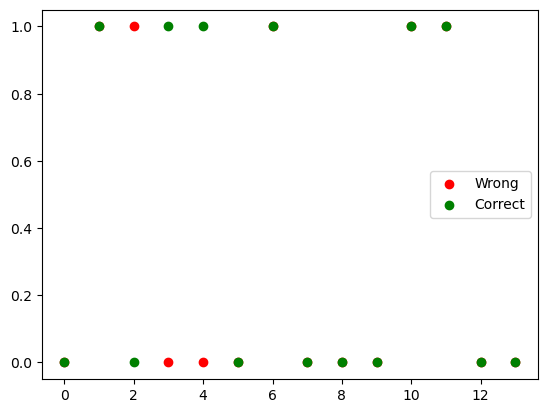

In [283]:
x = [x for x in range(len(xTest))]
plt.scatter(x, pred, color="red")
plt.scatter(x, yTest, color="green")
plt.legend(["Wrong", "Correct"])
plt.show()

In [284]:
df = shuffle(df, random_state=30)
X = df.drop(columns=["output"])
y = df["output"]

In [285]:
def crossVal(classifier, num_splits):
    scores = cross_val_score(classifier, X, y, cv = num_splits)
    print("Accuracy Scores : ", scores)
    print("Mean Accuracy Score : ", scores.mean())

In [287]:
crossVal(xgb, 10)

Accuracy Scores :  [0.78571429 0.78571429 0.64285714 1.         0.78571429 1.
 0.78571429 0.85714286 0.35714286 0.85714286]
Mean Accuracy Score :  0.7857142857142856


In [288]:
params = {
    "n_estimators" : [50, 100, 200],
    "max_depth" : [1],
    "learning_rate" : [0.08, 0.09, 0.1, 0.2],
    "num_parallel_tree" : [2, 3, 4],
    "reg_alpha" : [0.8, 0.9, 1.2],
    "reg_lambda" : [0.1, 0.2, 0.3]
}

In [289]:
gridXGB = GridSearchCV(xgb, params, n_jobs=-1, scoring="f1")
gridXGB.fit(xTrain, yTrain)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='error', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, ma...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='binary:hinge', predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.08, 0.09, 0.1, 0.2],
                         'max_depth': [1], 'n_estimators': [50, 100, 200],
                         'num_parallel_tree': [2, 3, 4],
                         'reg_alpha': [0.8, 0.9, 1.2],
                         'reg_lambda': [0.1, 0.2, 0.3]},
             scoring='f1')

In [290]:
bestParams = gridXGB.best_params_
bestParams

{'learning_rate': 0.2,
 'max_depth': 1,
 'n_estimators': 200,
 'num_parallel_tree': 2,
 'reg_alpha': 1.2,
 'reg_lambda': 0.3}

In [291]:
bestModel = gridXGB.best_estimator_
bestModel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=2,
              objective='binary:hinge', predictor=None, ...)

In [292]:
yPred = bestModel.predict(xTest)

In [293]:
cm = confusion_matrix(yPred, yTest)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
totalP = TP+FP
totalN = TN+FN
total = totalN + totalP

acc = (TP+TN)/(totalN+totalP)
acc*=100

print("Total : ", total, "\n")
print("True +ve :  ", TP, "     ", "{:.2f}".format((TP/totalP)*100), "%")
print("True -ve :  ", TN, "     " ,"{:.2f}".format((TN/totalN)*100), "%")
print("False +ve : ", FP, "      ", "{:.2f}".format((FP/totalP)*100), "%")
print("False -ve   ", FN, "      ", "{:.2f}".format((FN/totalN)*100), "%")
print("\n")
print("Accuracy :  ", "{:.2f}".format(acc), "%")



Total :  14 

True +ve :   7       87.50 %
True -ve :   3       50.00 %
False +ve :  1        12.50 %
False -ve    3        50.00 %


Accuracy :   71.43 %


In [294]:
crossVal(bestModel, 5)

Accuracy Scores :  [0.85714286 0.67857143 0.92857143 0.75       0.78571429]
Mean Accuracy Score :  0.8


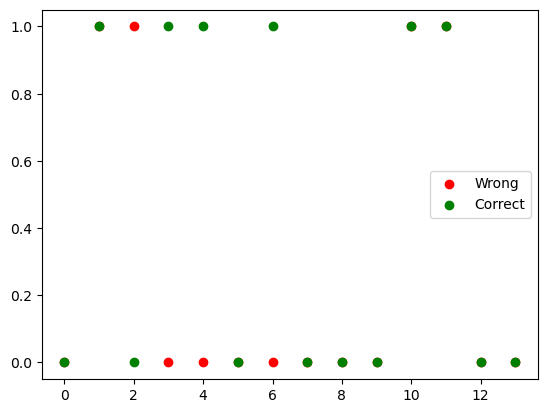

In [295]:
x = [x for x in range(len(xTest))]
plt.scatter(x, yPred, color="red")
plt.scatter(x, yTest, color="green")
plt.legend(["Wrong", "Correct"])
plt.show()

In [267]:
bestModel.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=2,
              objective='binary:hinge', predictor=None, ...)

In [268]:
crossVal(bestModel, 5)

Accuracy Scores :  [0.89285714 0.89285714 0.71428571 0.71428571 0.82142857]
Mean Accuracy Score :  0.8071428571428572


In [269]:
Pred = bestModel.predict(xTest)

In [270]:
cm = confusion_matrix(Pred, yTest)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
totalP = TP+FP
totalN = TN+FN

acc = (TP+TN)/(totalN+totalP)
acc*=100

print("Total : ", total, "\n")
print("True +ve :  ", TP, "     ", "{:.2f}".format((TP/totalP)*100), "%")
print("True -ve :  ", TN, "     " ,"{:.2f}".format((TN/totalN)*100), "%")
print("False +ve : ", FP, "      ", "{:.2f}".format((FP/totalP)*100), "%")
print("False -ve   ", FN, "      ", "{:.2f}".format((FN/totalN)*100), "%")
print("\n")
print("Accuracy :  ", "{:.2f}".format(acc), "%")



Total :  28 

True +ve :   6       50.00 %
True -ve :   14       87.50 %
False +ve :  6        50.00 %
False -ve    2        12.50 %


Accuracy :   71.43 %


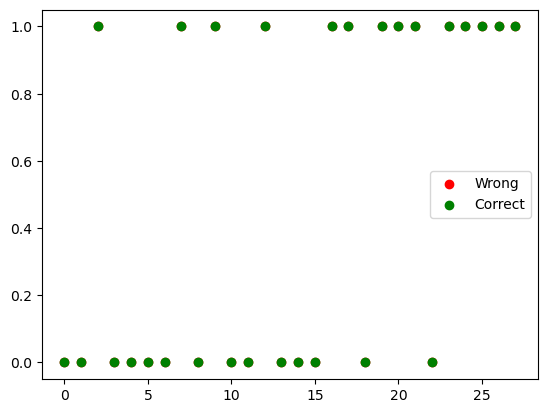

In [104]:
x = [x for x in range(len(xTest))]
plt.scatter(x, Pred, color="red")
plt.scatter(x, yTest, color="green")
plt.legend(["Wrong", "Correct"])
plt.show()

In [1859]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [1860]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Models')

In [1861]:
bestModel.save_model("InvoiceDateXGBoost.json")

In [1862]:
model = XGBClassifier()

In [1863]:
model.load_model("InvoiceDateXGBoost.json")

In [1864]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset')

In [1865]:
testDF = pd.read_csv("test.csv")

In [1866]:
testDF

,Unnamed: 0,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,...,due date x,date x,dated x,invoice date y,invoice dt y,due date y,date y,dated y,imageName,output
0,17,29/12/2023,0.721569,0.326061,3300,2550,0,0,0,0,...,0.659216,0.664314,0.664314,0.096364,0.096364,0.196061,0.196061,0.196061,1,0
1,15,30/01/2023,0.940392,0.194545,3300,2550,0,0,0,0,...,0.000000,0.680784,0.680784,0.096364,0.096364,0.000000,0.096667,0.096667,1,0
2,14,31/12/2022,0.940784,0.095152,3300,2550,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.094848,0.000000,0.000000,0.000000,1,1
3,13,29/12/2023,0.721569,0.326061,3300,2550,0,0,0,0,...,0.659216,0.664314,0.664314,0.096364,0.096364,0.196061,0.196061,0.196061,1,0
4,12,30/12/2022,0.614118,0.326061,3300,2550,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
5,11,30/01/2023,0.940392,0.194545,3300,2550,0,0,0,0,...,0.000000,0.680784,0.680784,0.096364,0.096364,0.000000,0.096667,0.096667,1,0
6,10,31/12/2022,0.940784,0.095152,3300,2550,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.094848,0.000000,0.000000,0.000000,1,1
7,16,30/12/2022,0.614118,0.326061,3300,2550,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
8,9,to 13-sep-2023,0.365323,0.347777,3508,2480,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
9,0,14/09/2022,0.151613,0.049601,3508,2480,0,0,0,0,...,0.000000,0.070161,0.070161,0.000000,0.000000,0.000000,0.049601,0.049601,3,0


In [1867]:
testDF.drop_duplicates(subset=["x", "y", "imageName", "output"], keep="first", inplace=True)

In [1868]:
testDF

,Unnamed: 0,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,...,due date x,date x,dated x,invoice date y,invoice dt y,due date y,date y,dated y,imageName,output
0,17,29/12/2023,0.721569,0.326061,3300,2550,0,0,0,0,...,0.659216,0.664314,0.664314,0.096364,0.096364,0.196061,0.196061,0.196061,1,0
1,15,30/01/2023,0.940392,0.194545,3300,2550,0,0,0,0,...,0.000000,0.680784,0.680784,0.096364,0.096364,0.000000,0.096667,0.096667,1,0
2,14,31/12/2022,0.940784,0.095152,3300,2550,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.094848,0.000000,0.000000,0.000000,1,1
4,12,30/12/2022,0.614118,0.326061,3300,2550,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
8,9,to 13-sep-2023,0.365323,0.347777,3508,2480,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
9,0,14/09/2022,0.151613,0.049601,3508,2480,0,0,0,0,...,0.000000,0.070161,0.070161,0.000000,0.000000,0.000000,0.049601,0.049601,3,0
10,6,subscription)14-sep-2022 to,0.363710,0.285348,3508,2480,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
11,5,14/09/2022,0.151613,0.049601,3508,2480,0,0,0,0,...,0.000000,0.070161,0.070161,0.000000,0.000000,0.000000,0.049601,0.049601,3,1
12,4,13-sep-2023,0.368548,0.346636,3508,2480,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
13,3,14-sep-2022,0.295968,0.346351,3508,2480,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0


In [1869]:
testDF.drop(columns=["Unnamed: 0"], inplace=True)

In [1870]:
testDF.sort_values("imageName", inplace=True)

In [1871]:
testDF["dateRank"] = 0

In [1872]:
for index in testDF.index:
    text = testDF["text"][index]
    dates = list(datefinder.find_dates(text, strict=True))
    date = dates[0]
    testDF["text"][index] = date

/tmp/ipykernel_6242/3468088821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDF["text"][index] = date


In [1873]:
testDF

,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice date,...,date x,dated x,invoice date y,invoice dt y,due date y,date y,dated y,imageName,output,dateRank
0,2023-12-29 00:00:00,0.721569,0.326061,3300,2550,0,0,0,0,1,...,0.664314,0.664314,0.096364,0.096364,0.196061,0.196061,0.196061,1,0,0
1,2023-01-30 00:00:00,0.940392,0.194545,3300,2550,0,0,0,0,1,...,0.680784,0.680784,0.096364,0.096364,0.000000,0.096667,0.096667,1,0,0
2,2022-12-31 00:00:00,0.940784,0.095152,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.094848,0.000000,0.000000,0.000000,1,1,0
4,2022-12-30 00:00:00,0.614118,0.326061,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0
8,2023-09-13 00:00:00,0.365323,0.347777,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,0
9,2022-09-14 00:00:00,0.151613,0.049601,3508,2480,0,0,0,0,0,...,0.070161,0.070161,0.000000,0.000000,0.000000,0.049601,0.049601,3,0,0
10,2022-09-14 00:00:00,0.363710,0.285348,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,0
11,2022-09-14 00:00:00,0.151613,0.049601,3508,2480,0,0,0,0,0,...,0.070161,0.070161,0.000000,0.000000,0.000000,0.049601,0.049601,3,1,0
12,2023-09-13 00:00:00,0.368548,0.346636,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,0
13,2022-09-14 00:00:00,0.295968,0.346351,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,0


In [1874]:
for imagename in testDF["imageName"].unique():
    dates = []
    for index in testDF.index:
        if testDF["imageName"][index]==imagename:
            if testDF["text"][index] not in dates:
                dates.append(testDF["text"][index])
    ranking = {}
    i=0
    while len(dates)>0:
        minm = min(dates)
        ranking[minm] = i
        i+=1
        I = dates.index(minm)
        dates.pop(I)
    for index in testDF.index:
        if testDF["imageName"][index]==imagename:
            testDF["dateRank"][index] = ranking[testDF["text"][index]]
    
        

/tmp/ipykernel_6242/1923372943.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDF["dateRank"][index] = ranking[testDF["text"][index]]


In [1875]:
testDF

,text,x,y,PageHeight,PageWidth,isTop,isBottom,isRight,isLeft,invoice date,...,date x,dated x,invoice date y,invoice dt y,due date y,date y,dated y,imageName,output,dateRank
0,2023-12-29 00:00:00,0.721569,0.326061,3300,2550,0,0,0,0,1,...,0.664314,0.664314,0.096364,0.096364,0.196061,0.196061,0.196061,1,0,3
1,2023-01-30 00:00:00,0.940392,0.194545,3300,2550,0,0,0,0,1,...,0.680784,0.680784,0.096364,0.096364,0.000000,0.096667,0.096667,1,0,2
2,2022-12-31 00:00:00,0.940784,0.095152,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.094848,0.000000,0.000000,0.000000,1,1,1
4,2022-12-30 00:00:00,0.614118,0.326061,3300,2550,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0
8,2023-09-13 00:00:00,0.365323,0.347777,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,1
9,2022-09-14 00:00:00,0.151613,0.049601,3508,2480,0,0,0,0,0,...,0.070161,0.070161,0.000000,0.000000,0.000000,0.049601,0.049601,3,0,0
10,2022-09-14 00:00:00,0.363710,0.285348,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,0
11,2022-09-14 00:00:00,0.151613,0.049601,3508,2480,0,0,0,0,0,...,0.070161,0.070161,0.000000,0.000000,0.000000,0.049601,0.049601,3,1,0
12,2023-09-13 00:00:00,0.368548,0.346636,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,1
13,2022-09-14 00:00:00,0.295968,0.346351,3508,2480,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0,0


In [1876]:
preProcess(testDF)

/tmp/ipykernel_6242/2509003301.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_6242/2509003301.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_6242/2509003301.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1


In [1877]:
testDF.dropna(inplace=True)
testDF.drop(columns=["isBottom", "isLeft", "invoice date y", "invoice dt y", "dated y", "due date", "date", "dated", "due date x", "date x", "dated x", "due date y", "date y"], inplace=True)

In [1878]:
testDF

,x,y,isTop,isRight,invoice date,invoice dt,invoice date x,invoice dt x,output,dateRank
0,721.568627,326.060606,1,1,1,1,675.686275,675.686275,0,3
1,940.392157,194.545455,1,1,1,1,675.686275,675.686275,0,2
2,940.784314,95.151515,1,1,0,1,0.000000,646.274510,1,1
4,614.117647,326.060606,1,1,0,0,0.000000,0.000000,0,0
8,365.322581,347.776511,1,0,0,0,0.000000,0.000000,0,1
9,151.612903,49.600912,1,0,0,0,0.000000,0.000000,0,0
10,363.709677,285.347777,1,0,0,0,0.000000,0.000000,0,0
11,151.612903,49.600912,1,0,0,0,0.000000,0.000000,1,0
12,368.548387,346.636260,1,0,0,0,0.000000,0.000000,0,1
13,295.967742,346.351197,1,0,0,0,0.000000,0.000000,0,0


In [1879]:
testDF = shuffle(testDF, random_state=10)

In [1880]:
X = testDF.drop(columns=["output"])
y = testDF["output"]

In [1881]:
testPred = model.predict(X)
testPred

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0])

In [1882]:
y.to_numpy()

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1883]:
cm = confusion_matrix(testPred, y)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
totalP = TP+FP
totalN = TN+FN
total = totalP + totalN

acc = (TP+TN)/(totalN+totalP)
acc*=100

print("Total : ", total, "\n")
print("True +ve :  ", TP, "     ", "{:.2f}".format((TP/totalP)*100), "%")
print("True -ve :  ", TN, "     " ,"{:.2f}".format((TN/totalN)*100), "%")
print("False +ve : ", FP, "      ", "{:.2f}".format((FP/totalP)*100), "%")
print("False -ve   ", FN, "      ", "{:.2f}".format((FN/totalN)*100), "%")
print("\n")
print("Accuracy :  ", "{:.2f}".format(acc), "%")



Total :  12 

True +ve :   7       70.00 %
True -ve :   1       50.00 %
False +ve :  3        30.00 %
False -ve    1        50.00 %


Accuracy :   66.67 %
